# Classification of handwritten digits
In this document we address a classification task. The goal is to find a function $f\in\mathcal Y^\mathcal X$ that given an input $x\in\mathcal X$ provides a class label $f(x)\in\mathcal Y$ in a way that to best fit some pre-defined (unknown) data distribution on $\mathcal X\times\mathcal Y$. More specifically, we address the problem of classifying handwritten digits. Accordingly, the input space $\mathcal X$ consists of gray-scale images of fixed resolution $h\times w$ representing handwritten digits from $0$ to $9$, and the label space is given by $\mathcal Y=\{0,\ldots,9\}$. Below we see some examples:
![Examples from MNIST](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

To get a representative sample of the distribution of handwritten digits, we consider a well-known dataset in the field called [MNIST](https://en.wikipedia.org/wiki/MNIST_database), which contains $70$k gray-scale images of handwritten digits from $0$ to $9$, each image being $28\times 28$ (so, $w=h=28$). 

Our goal in this document is to play with different machine learning algorithms, rather than pursuing the best absolute performance on this dataset. Accordinly, we will consider a subset of $20$k images that we split $10$k images for training, $5$k for validation and $5$k for test.



## MNIST

We start by loading and inspecting the MNIST dataset. To this end, we make use of scikit-learn to fetch MNIST's data. Note that the following instructions will take several seconds for the execution.

In [1]:
# Import the function to fetch MNIST from scikit-learn
from sklearn.datasets import fetch_openml

# Fetching MNIST data by returning digit images and targets in two tensors
# We call the tensor with input data X and the relative targets y
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

# NOTE: scikit-learn works with NumPy tensors instead of PyTorch tensors
# so X and y will be NumPy tensors

We next inspect the tensors we have and convert them from NumPy to PyTorch tensors, since we learnt to use them.

In [2]:
# Here we print the shapes of the two returned tensors
print("Shape of input data: {}".format(X.shape))
print("Shape of targets: {}".format(y.shape))

# Here we inspect the ranges of the elements of X and y
print("Minimum and maximum values in X. Min={} Max={}".format(X.min(), X.max()))
print("Minimum and maximum values in y. Min={} Max={}".format(y.min(), y.max()))

# Here we inspect the data types of the NumPy tensors
print("Data type of X: {}".format(X.dtype))
print("Data type of y: {}".format(y.dtype))

Shape of input data: (70000, 784)
Shape of targets: (70000,)
Minimum and maximum values in X. Min=pixel1      0.0
pixel2      0.0
pixel3      0.0
pixel4      0.0
pixel5      0.0
           ... 
pixel780    0.0
pixel781    0.0
pixel782    0.0
pixel783    0.0
pixel784    0.0
Length: 784, dtype: float64 Max=pixel1       0.0
pixel2       0.0
pixel3       0.0
pixel4       0.0
pixel5       0.0
            ... 
pixel780    62.0
pixel781     0.0
pixel782     0.0
pixel783     0.0
pixel784     0.0
Length: 784, dtype: float64


TypeError: Categorical is not ordered for operation min
you can use .as_ordered() to change the Categorical to an ordered one


From what we printed above we deduct the following information. The size of the input tensor $X$ is $70$k $\times 28^2$, i.e. each row of $X$ represents the $28\times 28$ digit image, linearized. The range of gray-scale values is $[0,255]$. The entries of $X$ are `float64`. As for $y$ we have one entry for each image, holding the relative class label. However the data type of the elements of $y$ is `object`. To actually figure out the real datatype, we inspect the content and type of the first element.

In [30]:
# Since the data type of y is not numeric but generic, we inspect the 
# single elements
print("Content of y[0]: {}. Type of y[0]: {}".format(y[0], type(y[0])))

Content of y[0]: 5. Type of y[0]: <class 'str'>


We found out that y contains digits in the form of strings instead of numbers. We convert now $X$ and $y$ to PyTorch tensors, paying attention of the fact that
$y$ contains strings.

In [31]:
# We import PyTorch libraries
import torch

# We a special function to convert from NumPy, 
# but torch.tensor could be used as well
X=torch.from_numpy(X)

# Here turn y into a list of numbers and get the PyTorch tensor via torch.tensor
y=torch.tensor([int(d) for d in y])

We will now use matplotlib to visualize some digits with the corresponding label.

Visualizing digits with index: tensor([  290, 49370,  5120, 36713, 55084, 68851, 43388,  9230, 26572, 59742])


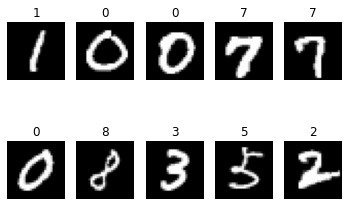

In [32]:
# Import libraries for plotting
import matplotlib.pyplot as plt

# We will need the ceil function that rounds to the next integer
from math import ceil

# Specify the number of digits to plot and the number of rows 
# in which to arrange the plots
num_random_digits=10
num_rows = 2

# We get the minimum number of columns required to show the plots given the 
# specified number of rows
num_cols= ceil(num_random_digits/num_rows)

# We sample num_random_digits distinct digit indices using randperm and slicing
random_indices = torch.randperm(X.shape[0])[:num_random_digits]

# We print the sampled indices
print("Visualizing digits with index: {}".format(random_indices))

# We visualize the plots in an arrangement of num_rows x num_cols

#For each random digit
for i in range(num_random_digits):
  # get the digit iindex
  digit_idx = random_indices[i]

  # subplot allows to organize plots into grids by specifying a grid size and 
  # selecting a grid cell
  ax=plt.subplot(num_rows, num_cols, i+1)

  # we disable the axes
  ax.axis('off')

  # We plot the digit by reshaping the row of X into a 28x28 2D tensor
  # We use imshow to plot the content of a 2D tensor
  plt.imshow(X[digit_idx].reshape(28,28), cmap='gray');

  # We put the digit label as title
  plt.title('{}'.format(y[digit_idx]));

Next, we have to reduce the number of samples from $70$k to $20$k since we will work with a reduced set.

In [33]:
# We keep track of the original data
X_full=X
y_full=y

# We select a subset of 20k training samples
rand_perm = torch.randperm(X.shape[0])[:20000]
X=X[rand_perm]
y=y[rand_perm]

Then, we have to split the data into a training set, validation set and test set of $10$k, $5$k and $5$k, respectively

In [34]:
# Compute the size of the three sets: training, validation ,test
split_sizes = [10000,5000,5000]

# We split the tensor according to the specified sizes using torch.split
Xtr, Xvl, Xts = X.split(split_sizes)
ytr, yvl, yts = y.split(split_sizes)

# We print the number of images assigned to each split as sanity check
print("Number of images: train {}, val {}, test {}"
        .format(*[s.shape[0] for s in [Xtr, Xvl, Xts]]))

Number of images: train 10000, val 5000, test 5000


To recap, the training set images are stored as rows of the 2D tensor $X_\text{tr}$ and the relative class labels are stored in the 1D tensor $y_\text{tr}$. Similarly we have the validation set in $X_\text{vl}$ and $y_\text{vl}$, and the test set in $X_\text{ts}$ and $y_\text{ts}$.

## Evaluation metrics
We consider three evaluation metrics:
* Global Accuracy (Acc): $\frac{\text{# correctly classified images}}{\text{# of images}}$
* Class Averaged Accuracy (mAcc): $\frac{1}{|\mathcal Y|}\sum_{y\in\mathcal Y} \frac{\text{# of correctly classified images of class $y$}}{\text{# of images of class $y$}}$
* Class averaged Intersection-over-Union (mIoU): $\frac{1}{|\mathcal Y|}\sum_{y\in\mathcal Y}\frac{\text{# of correctly classified images of class $y$}}{\text{# of images of class $y$ or predicted of class $y$}}$

We write a function to compute the three error metrics.

In [35]:
def evaluate(yt, yp, num_classes=10):
  # Computes the three metrics Acc, mAcc and mIoU
  # yt: 1D tensor of size n with the target class labels
  # yp: 1D tensor of size n with the predicted class labels
  # num_classes: total number of classes

  # Compute the confusion matrix C, where C_ij represents the number of images 
  # of class i classified with class j
  C=(yt*num_classes+yp).bincount(minlength=num_classes**2).view(num_classes,num_classes).float()

  # Alternatively one can use sklearn.metrics.confusion_matrix(yt,yp)

  return {
      # The diagonal of C holds the images that have been correctly classified, so
      # Acc can be computed as the sum of the diagonal divided by the number of images
      'Acc': C.diag().sum().item()/yt.shape[0],

      # For mAcc we need to divide the diagonal of C by the sum of each row of C
      # because the latter represents the number of images per class. This yields 
      # a tensor with the per-class accuracies. Finally, we average the result to 
      # get the mean per-class accuracy.
      'mAcc': (C.diag()/C.sum(-1)).mean().item(),

      # For the IoU computation we divide the diagonal of C by the sum of the columns
      # of C plus the sum of the rows of C minus the diagonal of C. This yeilds per-class
      # IoUs, which are finally averaged.
      'mIoU': (C.diag()/(C.sum(0)+C.sum(1)-C.diag())).mean().item()
  }

## Machine learning classification models
We will train the following machine learning models using scikit-learn, which have been addressed during the course:

* Decision Tree Classifier
* Random Forest
* Nearest Neghbour Classifier
* Support Vector Machines

For each model we will make an analysis of its performance.

### Decision Tree (DT) Classifier
A decision tree classifier can be defined in scikit-learn using the class [tree.DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decision%20tree#sklearn.tree.DecisionTreeClassifier).

We start by importing the library and inspect the arguments of the constructor.

In [36]:
# Import required library
from sklearn import tree

#This opens the documentation about the class
tree.DecisionTreeClassifier?

The instructions above import the required libraries and show the documentation about the class. We can see that when we create a `DecisionTreeClassification` object we can specify with `criterion` the quality measure (gini and entropy are available), whether we want to find the best (axis-aligned) split or a random one (see `splitter`), if we want to put conditions to stop the growth (`max_depth`, `min_samples_split`, `min_samples_leaf`, `max_leaf_nodes`, `min_impurity_decrease`, `min_impurity_split`), and other arguments.

We start creating a decision tree with the default parametrizations.

In [52]:
dtree = tree.DecisionTreeClassifier()

Similarly to what we have seen in the polynomial regression experiment, also this scikit-learn model exposes a function [`fit`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decision%20tree#sklearn.tree.DecisionTreeClassifier.fit) that can be used to train the model. 

In [53]:
# We will track the training/inference times of each method
import time
exec_times={}

# Trains a decision tree on the training set
# The execution takes few seconds
start=time.time()
dtree.fit(Xtr, ytr);
end=time.time()

exec_times['train']={
    'DT': end-start
}

print("Training time: {}s".format(exec_times['train']['DT']))

Training time: 2.683171510696411s


We can now gather some information about the trained model, in particular depth and number of leaves.

In [54]:
# Depth
print("Tree depth: {}".format(dtree.get_depth()))

# Number of leaves
print("Number of leaves: {}".format(dtree.get_n_leaves()))

Tree depth: 27
Number of leaves: 1027


We can further inspect the trained tree which is stored in `dtree.tree_`. We refer to the documentation about [tree structure](https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py) for more details. 

The tree is stored in terms of several arrays, being fields of `dtree.tree_`:
* `children_left`: array where the $i$th entry represents the index of the left child of node $i$
* `children_right`: same but for the right child
* `node_count`: number of nodes (leaves included) in the tree
* `feature`: array where the $i$th entry represents the index of the feature used by the split function in node $i$ (a negative value for leaves)
* `threshold`: array where the $i$th entry represents the threshold used by the split function in node $i$ 
* `value`: array where the $i$th entry holds the class probability distribution of training samples reaching that node 

As an example we will inspect the rule that has been applied to split the data at the root node. 

In [55]:
print("Feature used to split @ root: {}".format(dtree.tree_.feature[0]))
print("Threshold used to split @ root: {}".format(dtree.tree_.threshold[0]))

Feature used to split @ root: 350
Threshold used to split @ root: 96.5


We can visualize the position of the selected feature by plotting a black point there.

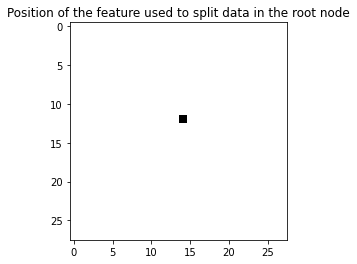

In [56]:
# Make an image with all ones
I=torch.ones(28,28)
# Set to zero the feature selected for the root
# To this end we need to view the 2D tensor as a 1D tensor and set to 0 the 
# entry corresponding to the selected feature
I.view(-1)[dtree.tree_.feature[0]]=0

# Plot the image
plt.imshow(I, cmap='gray');
plt.title("Position of the feature used to split data in the root node");

Next, we can plot the distribution of the selected features across all nodes, to have an idea of where the most used features are.

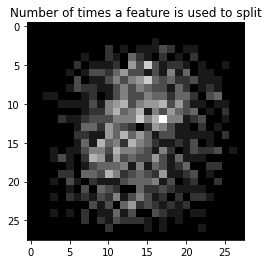

In [57]:
# The following two lines of code generate in feat_distrib a 1D tensor of 
# size 28**2, where each entry, say j, counts the number of occurences of the 
# jth feature
feat_distrib=torch.tensor(dtree.tree_.feature)
feat_distrib=feat_distrib[feat_distrib>=0].bincount(minlength=28**2)

# We visualize the distribution
plt.imshow(feat_distrib.view(28,28), cmap='gray');
plt.title("Number of times a feature is used to split");

The saliency of the features correlates with where the digits are typically placed within the image. This way of computing the importance of the features does not take into account how many samples of the training set were split by a given feature, e.g. the split decision in the root is way more important than a split decision close to a leaf. A better estimate of the importance requires weighting each feature by the number of samples thatit splits. This can be obtained from scikit-learn using the field `dtree.feature_importances_`, which in our case is a $28**2$ long 1D tensor of weights.

We visualize the properly-weighted importance of the features below.

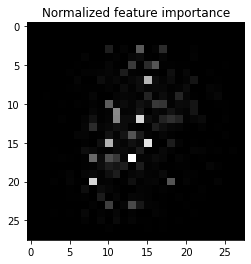

In [58]:
# We visualize the feature importance after properly reshaping it in a 28x28 2D tensor
plt.imshow(dtree.feature_importances_.reshape(28,28), cmap='gray');
plt.title("Normalized feature importance");

Next we inspect the class distribution of the training set after the split in the root node.

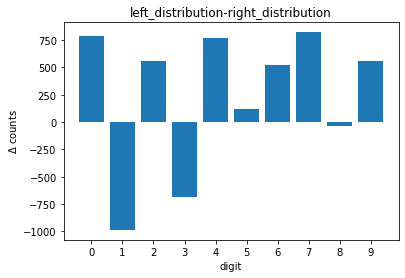

In [59]:
# Creates a 1D boolean tensor indicating which image is routed left
routed_left=Xtr[:,dtree.tree_.feature[0]]<=dtree.tree_.threshold[0]

# Creates a histogram of class labels of images routed left
left_distribution = ytr[routed_left].bincount(minlength=10)

# Creates a histogram of class labels of images routed right
right_distribution = ytr[~routed_left].bincount(minlength=10)

# Produces a bar plot of the difference between left and right histograms
plt.bar(range(10), left_distribution-right_distribution)
plt.title('left_distribution-right_distribution')
plt.xlabel('digit')
plt.ylabel('$\Delta$ counts')
plt.xticks(range(10));


We can additionally try to visualize the average image of digits being routed to the left and to the right.

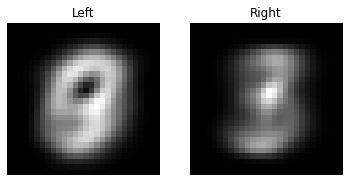

In [60]:
# Compute the average digit from images routed to the left
mean_left = Xtr[routed_left].sum(0).view(28,28)
# Compute the average digit from images routed to the right
mean_right = Xtr[~routed_left].sum(0).view(28,28)

# Plots the left and right average digits
ax=plt.subplot(1,2,1)
plt.imshow(mean_left, cmap='gray')
ax.axis('off')
plt.title("Left")
ax=plt.subplot(1,2,2)
ax.axis('off')
plt.imshow(mean_right, cmap='gray')
plt.title("Right");

We compute now how the trained model performs on the training data and validation data. To this end, we use the method [`predict`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.predict) to classify the training and validation data and use the evaluation function we have defined to compute the performance.

In [61]:
# Compute predictions on training data
ytr_p = dtree.predict(Xtr)

# Compute predictions on validation data and track execution time
start = time.time()
yvl_p = dtree.predict(Xvl)
end = time.time()
exec_times['val']={
    'DT': end-start
}

# Cast to PyTorch tensors
ytr_p=torch.from_numpy(ytr_p)
yvl_p=torch.from_numpy(yvl_p)

# Print results
print("Performance on training: {}".format(evaluate(ytr, ytr_p)))
print("Performance on validation: {}".format(evaluate(yvl, yvl_p)))
print("Evaluation time: {}s".format(exec_times['val']['DT']))

Performance on training: {'Acc': 1.0, 'mAcc': 1.0, 'mIoU': 1.0}
Performance on validation: {'Acc': 0.8052, 'mAcc': 0.8035408854484558, 'mIoU': 0.6758352518081665}
Evaluation time: 0.014448881149291992s


We know that decision trees are prone to overfitting unless we control the complexity of the model in some way. Indeed, the performance of training is perfect, but we loose accuracy on the validation set.

We will now inspect some failure cases to understand whether those are due to ambiguous digits or bad generalization.

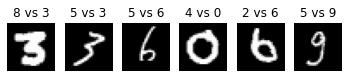

In [62]:
def visualize_failure_cases(X, yt, yp, num_failures_to_show=6):
  # Visualizes failure cases and return the indices of the visualized images
  # X: input data as a 2D tensor n x 28**2, each row being a linearized 28x28 image
  # yt: 1D tensor with n ground-truth labels
  # yp: 1D tensor with n predictions

  # returns indices of images that have been visualized

  # We determine which images are misclassified and store this in a boolean 1D tensor
  failures = yt != yp
  # We look for the indices of misclassified images and retain only the first num_failures_to_show ones.
  failures_to_show = failures.nonzero()[:num_failures_to_show,0]

  # We plot the images where we are failing. i.e. the one  with indec in failures_to_show
  # Each plot shows prediction vs target as title
  for i, failure_idx in enumerate(failures_to_show):
    ax=plt.subplot(1,num_failures_to_show,i+1)
    ax.axis('off')
    plt.imshow(X[failure_idx].view(28,28),cmap='gray')
    plt.title('{} vs {}'.format(yp[failure_idx].item(),yt[failure_idx].item()))
  return failures_to_show

# This calls the function we defined above on the validation set and stores the 
# indices that have been visualized in failures_to_show beccause it will be used
# later again
failures_to_show = visualize_failure_cases(Xvl, yvl, yvl_p)

We will now try to train a decision tree by restricting the minimum number of samples that we have in a leaf. We will try different values of this hyperparameter. We will also consider the possibility of using a different quality measure, i.e. entropy (gini is the default).

In [63]:
# We train 4 different models, i.e. each combination of min_samples_leaf in {1,5} and criterion in {"gini,"entropy"}
# This will take few seconds.
dtrees = [
    tree.DecisionTreeClassifier(min_samples_leaf=ms, criterion=criterion).fit(Xtr,ytr) 
    for ms in [1,5]
    for criterion in ["gini", "entropy"]
]

 We measure then the performance of each model on the validation set in order to select the best, along with the performance on the training set.

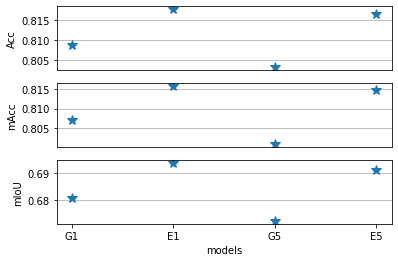

In [64]:
# We compute the predictions of each tree on the validation set in a list
dtree_predictions_vl = [dt.predict(Xvl) for dt in dtrees]

# We compute the performance of each model on the validation set in a list
dtree_performance_vl=[evaluate(yvl, yp) for yp in dtree_predictions_vl]

# We plot the performance of each model on each metric
for i,metric in enumerate(['Acc', 'mAcc', 'mIoU']):
  plt.subplot(3,1,i+1)
  curve_vl=[res[metric] for res in dtree_performance_vl]
  plt.plot(curve_vl,'*',markersize=10)
  plt.grid(axis="y")
  plt.ylabel(metric)
  # This removes the labels from the x-axis
  plt.xticks([])

# We give a name to each model we have: 
# G1: criterion=gini, num_samples_leaf=1
# E1: criterion=entropy, num_samples_leaf=1
# G5: criterion=gini, num_samples_leaf=5
# E5: criterion=entropy, num_samples_leaf=5
dt_model_names=['G1', 'E1', 'G5', 'E5']

# We set the x-axis labels only for the last plot
plt.xlabel('models')
plt.xticks(range(4),dt_model_names);


We can now identify the model yielding the best validation performance, although there are little differences across the models. We observe that the use of the entropy criterion improves over Gini when we have an unconstrained tree. We can now check whether the best model improved over the previously selected failure cases. 


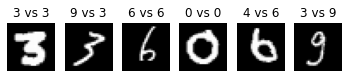

In [65]:
# We select the best model based on the mAcc metric
best_dt_model_idx = torch.tensor([res['mAcc'] for res in dtree_performance_vl]).argmax()

# We plot the images where we failing previously (stored in failures_to_show)
# Each plot shows prediction vs target
for i, failure_idx in enumerate(failures_to_show):
  ax=plt.subplot(1,len(failures_to_show),i+1)
  ax.axis('off')
  plt.imshow(Xvl[failure_idx].view(28,28),cmap='gray')
  plt.title('{} vs {}'.format(dtree_predictions_vl[best_dt_model_idx][failure_idx].item(),yvl[failure_idx].item()))

Indeed, we provide now some correct answers for some previous failure cases, but new errors could have popped up for other images. Nonetheless, from the plot above we know that overall there was an improvement on the validation set. However, this does not guarantee that the selected model achieves a better generalization error, because the selection inherited some bits of information about the validation set, thus biasing the model towards it.
To get a better (unbiased) estimate of the generalization performance we rely on the test set.

In [66]:
# We compute the predictions on the test set for the best model
test_predictions_dt = dtrees[best_dt_model_idx].predict(Xts)
# We turn the result into a PyTorch tensor
test_predictions_dt = torch.from_numpy(test_predictions_dt)

# We keep the scores of the selected model in scores
# This will later hold also scores of different types of models
scores={}
scores['DT']=evaluate(yts, test_predictions_dt)

# We print the performance on the test set for the selected decision tree.
print("Test performance: {}".format(scores['DT']))

Test performance: {'Acc': 0.819, 'mAcc': 0.814891517162323, 'mIoU': 0.6958524584770203}


This is the score that we will use to compare against other models.

### Random Forest (RF)

A single decision tree tends to overfit the training data, unless we reduce the tree complexity, but also in that case, the algorithm used to grow the tree does not guarantee to find a model with minimal complexity. We have seen that for this specific example, the heuristic of stopping the tree growth based on the minimum number of samples in the leaf was of little/no effect. 

A better approach to improve on the generalization performance is by means of ensembles of possibly uncorrelated low-bias models. Decision trees are great candidates models to form an ensemble and in order to render them less correlated we can train them by randomly sampling features and by perturbing the training set for each tree via e.g. bagging. 

Random Forest is a popular machine learning model that consists in an ensemble of decision trees. We can create such a model in scikit-learn via [`ensemble.RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn-ensemble-randomforestclassifier). 



In [74]:
# Import required libraries
from sklearn import ensemble

#Visualize help
ensemble.RandomForestClassifier?

This class shares the same arguments for the constructor that we have seen for decision trees, but has also additional ones such as `n_estimators`, which holds the number of trees we want to have in the ensemble, and `boostrap`, which enables boostrapping of the training set when growing each tree (enabled by default).

We have seen that the best criterion seems to be entropy over gini. Moreover, ensembles are more effective if the single models have low bias, so we do not enforce stopping criteria that reduce the complexity of single trees. We set the number of trees in the ensemble to $20$ in order to keep the training time short.

In [75]:
# We create a random forest model with 10 trees and entropy criterion
rf_model = ensemble.RandomForestClassifier(n_estimators=20, criterion="entropy")

Next, we train the forest on the training data using the usual [`fit`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.fit) function.

In [76]:
# We train the random forest model on the training set and track training time
start = time.time()
rf_model.fit(Xtr, ytr);
end = time.time()

exec_times['train']['RF']=end-start

print("Training time: {}s".format(exec_times['train']['RF']))

Training time: 2.457244873046875s


Each trained tree can be accessed in the list `rf_model.estimators_`.

We compute next the performance on training and validation using the [`predict`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict) method to classify, which internally computes the prediction of each tree in the ensemble and performs a probability-weighted voting.

In [77]:
# Compute prediction for the training and validation sets and track time of validation
rf_prediction_tr = rf_model.predict(Xtr)

start = time.time()
rf_prediction_vl = rf_model.predict(Xvl)
end = time.time()

exec_times['val']['RF']=end-start

# Cast the predictions into PyTorch tensors
rf_prediction_tr = torch.from_numpy(rf_prediction_tr)
rf_prediction_vl = torch.from_numpy(rf_prediction_vl)

# Print the training and validation performance
print("Performance on training: {}".format(evaluate(ytr, rf_prediction_tr)))
print("Performance on validation: {}".format(evaluate(yvl, rf_prediction_vl)))
print("Evaluation time: {}s".format(exec_times['val']['RF']))

Performance on training: {'Acc': 1.0, 'mAcc': 1.0, 'mIoU': 1.0}
Performance on validation: {'Acc': 0.9358, 'mAcc': 0.9347132444381714, 'mIoU': 0.8785508275032043}
Evaluation time: 0.05629086494445801s


As we can see the performance on validation is considerably higher than what we got with a single decision tree. Also, the performance on the training set is not perfect, but almost, due to the presence of bagging, which might leave some data out from the training set of each tree.

Next, we visualize some failure cases.

tensor([ 2, 30, 32, 33, 57, 69])

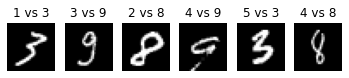

In [78]:
# This visualizes some failure cases
visualize_failure_cases(Xvl, yvl, rf_prediction_vl)

We will now change the number of trees in the ensemble in the range $\{3,\ldots,20\}$ and report the validation performance.

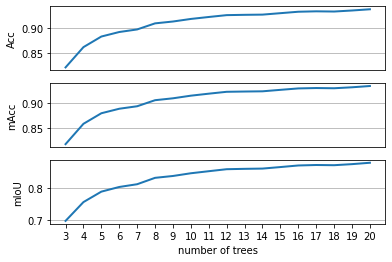

In [79]:
# Make a temporary copy of all trees in the forest
all_trees=rf_model.estimators_

# Init the forest model with only the first 2 trees
rf_model.estimators_ = [all_trees[i] for i in range(2)]

# We will now iteratively add one tree at time and compute the score
# in order to report the performance as we add more trees to the
# ensemble

curve_val={'Acc':[], 'mAcc':[], 'mIoU':[] }

# For all remaining trees
for i in range(2,len(all_trees)):

  # We add the next tree
  rf_model.estimators_.append(all_trees[i])

  # Compute the prediction on validation of the updated ensemble
  rf_prediction_vl = rf_model.predict(Xvl)

  # Cast to PyTorch tensor
  rf_prediction_vl = torch.from_numpy(rf_prediction_vl)

  # Evaluate the result and update the Acc, mAcc and mIoU curves
  res = evaluate(yvl, rf_prediction_vl)
  for k in res:
    curve_val[k].append(res[k])

# Finally we plot the curves for each metric
for i,metric in enumerate(curve_val.keys()):
  plt.subplot(3,1,i+1)
  plt.plot(range(3,len(all_trees)+1), curve_val[metric], linewidth=2)
  plt.ylabel(metric)
  # We keep the x-axis only for the last plot
  plt.xticks([])
  plt.grid(axis="y")
plt.xlabel('number of trees')
plt.xticks(range(3,len(all_trees)+1));

As the number of trees in the ensemble increases, the performance on validation increases. 

We finally report the score on the test set.

In [80]:
# Compute predictions for the test set
rf_prediction_ts = rf_model.predict(Xts)

# Cast to PyTorch tensor
rf_prediction_ts = torch.from_numpy(rf_prediction_ts)

# Print the 
scores['RF']=evaluate(yts, rf_prediction_ts)
print("Performance on test: {}".format(scores['RF']))

Performance on test: {'Acc': 0.9294, 'mAcc': 0.9281624555587769, 'mIoU': 0.8675651550292969}


### Nearest Neighbor (NN) Classifier

A Nearest Neighbor classifier is a non-parametric model that has no learnable parameters, but uses the entire training set every time it requires to perform a prediction. Indeed, given an input sample to predict, the NN classifier first retrieves a number of training samples that are close to the one we intend to predict, according to a predefined distance metric, and determines the output class from a possibly-weighted voting procedure. In order to perform inference in an efficient way, the NN classifier adopts typically tree-based datastructures to speedup the search for neighbors. 

In scikit-learn we can create a nearest neighbor classifier using the class [`neighbors.KNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier) or [`neighbors.RadiusNeighborsClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.RadiusNeighborsClassifier.html#sklearn.neighbors.RadiusNeighborsClassifier) depending on the type of NN algorithm we want to use. The former one searches for a fixed number of $K$ closest neighbors, while the latter searches for neighbors within a maximum radius.

In [81]:
# Import required libraries
from sklearn import neighbors

# Visualize help of KNN
neighbors.KNeighborsClassifier?

The constructor of `neighbors.KNeighborsClassifier` admits different arguments. The most relevant ones are `n_neighbors`, which is the desired number of neighbors $K$, `weights` (uniform or distance or user-defined) which specifies how the importance of a neighbor should be weighted, `metric` the distance metric to use.

In [82]:
# Visualize help of RadiusNN
neighbors.RadiusNeighborsClassifier?

The constructor of `neighbors.RadiusNeighborsClassifier` works similarly but instead of the number of neighbors admits a `radius` parameter. Another relevant argument here is `outlier_label` which deals with the case when no neighbors are found within the radius. In this case one can decide to assign the most frequent class across the dataset, or mark them with a user-specified label, or raise an exception.

We start by creating a KNN classifier with default parametrization.

In [83]:
# We initialize the nearest neighbor classifier. 
# Since inference can be very slow, we enable the use of multiple processes with n_jobs=-1
knn_model = neighbors.KNeighborsClassifier(n_jobs=-1)

Next we run [`fit`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.fit) on the training data in order to "train" the classifier. This will trigger the creation of the necessary datastructures that allows to quickly identify nearest neighbors during inference.

In [84]:
# We train a KNN model and track time
# It takes some seconds
start = time.time()
knn_model.fit(Xtr,ytr);
end = time.time()

exec_times['train']['kNN']=end-start

print("Training time: {}s".format(exec_times['train']['kNN']))

Training time: 1.1705646514892578s


We take now a random validation digit, visualize it and predict it with [`predict`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.predict).

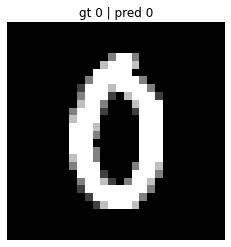

In [85]:
query_idx = torch.randint(0,Xvl.shape[0],(1,))

# Compute the prediction for the first validation image
prediction_knn = knn_model.predict(Xvl[query_idx])

# Plot the digit and in the title we report the ground-truth label and the predicted one
plt.imshow(Xvl[query_idx].view(28,28), cmap='gray')
plt.title('gt {} | pred {}'.format(yvl[query_idx].item(), prediction_knn[0]))
plt.axis('off');

Next we inspect what were the nearest neighbors for this validation image. We can use the method [`kneighbors`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.kneighbors). The latter function returns the indices of the nearest neghbors and their distance to the query points.

Distances: [1167.10753575 1441.24286642 1463.12371316 1475.32979364 1494.27407125]


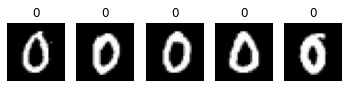

In [86]:
def plot_neighbors(knn_model, query):
  # Compute the nearest neighbors
  neighbors_dist, neighbors_idx = knn_model.kneighbors(query)

  # We Visualize them
  for i, (d, idx) in enumerate(zip(neighbors_dist[0], neighbors_idx[0])):
    ax=plt.subplot(1,len(neighbors_idx[0]), i+1)
    ax.axis('off')
    plt.imshow(Xtr[idx].view(28,28), cmap='gray')
    plt.title('{}'.format(ytr[idx]))

  print("Distances: {}".format(neighbors_dist[0]));

plot_neighbors(knn_model,Xvl[query_idx])

Due to the slowness of the inference procedure, we skip the use of the validation set for model selection (e.g. find an optimal value of the number of neighbors).

We will now predict the entire training and validation set and report performances.

In [87]:
# Compute prediction for the training and validation set and track time
# It takes roughly 3 minutes.
knn_prediction_tr = knn_model.predict(Xtr)

start = time.time()
knn_prediction_vl = knn_model.predict(Xvl)
end = time.time()

exec_times['val']['kNN']=end-start

# Cast the predictions into PyTorch tensors
knn_prediction_tr = torch.from_numpy(knn_prediction_tr)
knn_prediction_vl = torch.from_numpy(knn_prediction_vl)

# Print the validation performance
print("Performance on training: {}".format(evaluate(ytr, knn_prediction_tr)))
print("Performance on validation: {}".format(evaluate(yvl, knn_prediction_vl)))
print("Evaluation time: {}s".format(exec_times['val']['kNN']))


Performance on training: {'Acc': 0.9629, 'mAcc': 0.9626719355583191, 'mIoU': 0.928770899772644}
Performance on validation: {'Acc': 0.9484, 'mAcc': 0.9477372169494629, 'mIoU': 0.9016240835189819}
Evaluation time: 66.83948302268982s


We will next inspect some failure cases.

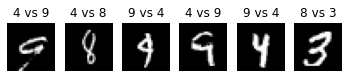

In [88]:
# This visualizes some failure cases
failure_cases = visualize_failure_cases(Xvl, yvl, knn_prediction_vl)

Next, we visualize the nearest neighbors of the first failure case in the list.

Distances: [1643.07151396 1707.13971309 1709.19922771 1715.83099401 1733.25070316]


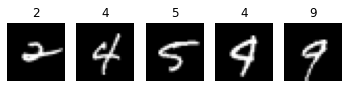

In [89]:
# Visualize nearest neighbors of the failure case
plot_neighbors(knn_model, Xvl[failure_cases[0:1]])

Finally we compute the scores for the test set.

In [90]:
# Compute prediction for the test set
# It takes roughly 1 minute.
knn_prediction_ts = knn_model.predict(Xts)

# Cast the predictions into PyTorch tensors
knn_prediction_ts = torch.from_numpy(knn_prediction_ts)

scores['kNN']=evaluate(yts, knn_prediction_ts)

# Print the test performance
print("\nPerformance on test: {}".format(scores['kNN']))


Performance on test: {'Acc': 0.9476, 'mAcc': 0.9468550682067871, 'mIoU': 0.9000250101089478}


### Support Vector Machine (SVM)

Finally, we evaluate the performance of Support Vector Machines, namely robust linear classifiers that can become non-linear by employing suitable kernel functions. SVMs are binary by nature, but can deal with multiple classes by casting the multi-class classification problem into a sequence of binary classification problems (one-vs-all, all-vs-all, and others).

In scikit-learn there are different classes that can be used to train SVMs for classification among which we find [`svm.SVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC), [`svm.NuSVM`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVC.html#sklearn.svm.NuSVC) and [`svm.LinearSVC`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC). We will use the first one, which is the SVM formulation presented during the course and can deal with kernels, as opposed to `LinearSVC`, which is faster but implements only linear SVMs. The second one is a different SVM formulation which has not been presented during the course, so it will be skipped.

In [91]:
# Import required libraries
from sklearn import svm

# Visualize help
svm.SVC?

The relevant arguments for the constructor are `C`, which balances the importance of the regularizer (inversely proportional), `kernel` (linear, poly, rbf, sigmoid or user-specified) which allows to specify the desired kernel function. Based on the kernel selection there are a number of kernel-specify parameters. Multi-class predictions are addressed with a all-vs-all strategy.

We start by initializing a C-SVM with default parametrization.

In [92]:
# Intialize a C-SVM model
svm_model = svm.SVC()

Next, we train the SVM model on the training set, using the usual [`fit`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.fit) function.

In [93]:
# Train the C-SVM on the training set and track time
# It takes several seconds
start = time.time()
svm_model.fit(Xtr, ytr);
end = time.time()

exec_times['train']['SVM']=end-start

print("Training time: {}s".format(exec_times['train']['SVM']))

Training time: 42.84548592567444s


We can inspect the trained model using the following fields:
* `support_`: array of indices of support vectors
* `support_vectors_`: array of training samples representing the support vectors
* `n_support_`: array with the number of support vectors for each class
* `coeff_`: weights of the SVM solution (only for linear kernel)
* `dual_coeff_`: dual variables of the SVM solution
* `intercept_`: constant in the decision function

We will print the number of support vectors.

In [94]:
print("Number of support vectors per class: {}".format(svm_model.n_support_))

Number of support vectors per class: [273 177 424 445 439 486 311 359 515 506]


Next, we compute the performance on both the training and validation sets using the [`predict`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.predict) function.

In [95]:
# Compute prediction for the training and validation set and track evaluation time
# It takes a bit more than 1 minute.
svm_prediction_tr = svm_model.predict(Xtr)

start = time.time()
svm_prediction_vl = svm_model.predict(Xvl)
end = time.time()

exec_times['val']['SVM']=end-start


# Cast the predictions into PyTorch tensors
svm_prediction_tr = torch.from_numpy(svm_prediction_tr)
svm_prediction_vl = torch.from_numpy(svm_prediction_vl)

# Print the training and validation performance
print("Performance on training: {}".format(evaluate(ytr, svm_prediction_tr)))
print("Performance on validation: {}".format(evaluate(yvl, svm_prediction_vl)))
print("Evaluation time: {}s".format(exec_times['val']['SVM']))

Performance on training: {'Acc': 0.9845, 'mAcc': 0.9845690727233887, 'mIoU': 0.969642162322998}
Performance on validation: {'Acc': 0.9634, 'mAcc': 0.9629584550857544, 'mIoU': 0.9290515184402466}
Evaluation time: 30.279833555221558s


We visualize some failure cases.

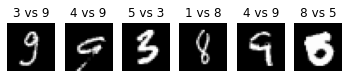

In [96]:
failures_to_show=visualize_failure_cases(Xvl, yvl, svm_prediction_vl);

Now, we train several SVM models using different kernels and values of $C$.

In [97]:
# We initialize and train models with all combinations of kernel in {rbf, poly, linear}
# and C in {0.1,1,10}. For each kernel we keep the standard parametrization
# It takes almost 6 minutes
svm_models = [svm.SVC(kernel=kernel, C=C).fit(Xtr, ytr) 
              for kernel in ['rbf', 'linear', 'poly'] 
              for C in [0.1, 1, 10]
              ]

We compute the performance on the validation set.

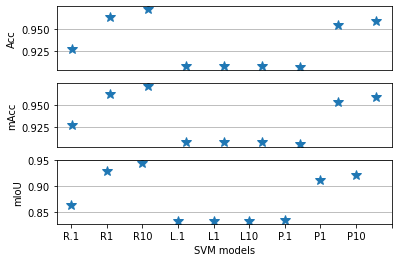

In [ ]:
# Compute predictions on validation for each model
# It takes 3/4 minutes

svms_predictions_vl = [svm.predict(Xvl) for svm in svm_models]

# Evaluate the performance of each model
svms_performance_vl = [evaluate(yvl, yp) for yp in svms_predictions_vl]

# Produce the plot about the performance of each model on each metric
for i,metric in enumerate(["Acc", "mAcc", "mIoU"]):
  plt.subplot(3,1,i+1)
  curve_vl=[res[metric] for res in svms_performance_vl]
  plt.plot(curve_vl,'*',markersize=10)
  plt.ylabel(metric)
  plt.grid(axis="y")
  plt.xticks([])

svm_model_names = [
  "R.1", "R1", "R10",
  "L.1", "L1", "L10",
  "P.1", "P1", "P10",
]
plt.xticks(range(10), svm_model_names)
plt.xlabel("SVM models"); 


We select the best model and check the performance on the selected failure cases of the previous model.

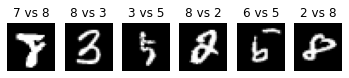

In [ ]:
# We select the best model based on the mAcc metric
best_svm_model_idx = torch.tensor([res['mAcc'] for res in svms_performance_vl]).argmax()

# We plot the images where we failing previously (stored in failures_to_show)
# Each plot shows prediction vs target
for i, failure_idx in enumerate(failures_to_show):
  ax=plt.subplot(1,len(failures_to_show),i+1)
  ax.axis('off')
  plt.imshow(Xvl[failure_idx].view(28,28),cmap='gray')
  plt.title('{} vs {}'.format(svms_predictions_vl[best_svm_model_idx][failure_idx].item(),yvl[failure_idx].item()))

Finally we compute the performance of the best model on the test set.

In [ ]:
# We compute the predictions on the test set for the best model
# It takes several seconds
test_predictions_svm = svm_models[best_svm_model_idx].predict(Xts)
# We turn the result into a PyTorch tensor
test_predictions_svm = torch.from_numpy(test_predictions_svm)

scores['SVM']=evaluate(yts, test_predictions_svm)

# We print the performance on the test set for the selected svm model.
print("Test performance: {}".format(scores['SVM']))

Test performance: {'Acc': 0.9624, 'mAcc': 0.9620243310928345, 'mIoU': 0.9271000027656555}


# Comparisons
We conclude with a number of scatter plots comparing the performance of the different best models for each performance metric against the time that was required for training and inference.

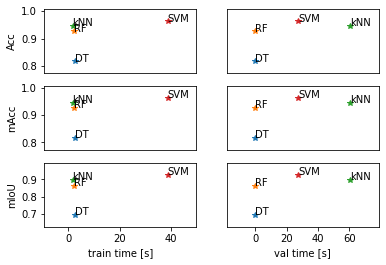

In [ ]:
# We retrieve the model names from the keys of the scores dictionary
models = list(scores.keys())

plot_idx = 1

# We produce a scatter plot for each combination of metric on the y-axis and  
# training/validation time on the x-axis
for metric in ["Acc", "mAcc", "mIoU"]:
  for dataset in ['train', 'val']:

    # We arrange the plots into a 3x2 grid
    plt.subplot(3,2,plot_idx)

    s = torch.tensor([scores[model][metric] for model in models])
    t = torch.tensor([exec_times[dataset][model] for model in models])

    plt.plot(t.view(1,-1),s.view(1,-1), '*')

    # This parts adds a label to each point in the scatter point, which in turn
    # corresponds to a particular model
    for i in range(len(models)):
      plt.annotate(models[i],(t[i],s[i]))

    # This adds some margin between axis and the points in the plot
    plt.margins(0.3)


    # The following if-the-else removes the y-axis from the second column of 
    # plots
    if dataset=='train':
      plt.ylabel(metric)
    else:
      plt.yticks([])

    # The following instruction enables the xaxis only for the last row of plots
    if metric=="mIoU":
      plt.xlabel('{} time [s]'.format(dataset))
    else:
      plt.xticks([])

    plot_idx+=1



In terms of accuracy, SVM wins the competition, although we did not conduct an extensive search of models for each type of classifier, however, it requires much longer training time compared to all other methods and longer inference time compared to RF and DT. kNNs achieve also good performance but at the cost of extremely slow inference. DTs can be trained fast and also inference is fast. However, a single tree does not generalize well. RFs, which provide an esemble of trees, provide a good trade-off of accuracy and training/inference speed. Note also that we limited ourself to $20$ trees, but larger ensembles could have been used.